# jupyter notebook related to __[coursera ML course](https://www.coursera.org/learn/machine-learning/)__

The course uses MATLAB, and so the main task here is
translating the MATLAB code for the various functions
(e.g. gradient descent solution for simple regression)
into a python equivalent.

I'm adding a new version of the notebook for every
week, as a convenience for myself to see the progress,
rather than having to go through the history on github.

### Settings (put at the top for ease of changing)

In [1]:
# size of sample (random) dataset
dataset_m = 50

# stopping criterion
stop_crit = 1.0e-12

# learning rate
learn_rate = 0.1

# regularization lambda
reg_lambda = 0.5

### Necessary libraries are imported

1. math (for functions such as fabs, ceil, log2, etc.)
2. numpy (for ndarray and associated functions)
3. matplotlib.pyplot (for plotting the theta and cost function values across iterations)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

And a brief function is defined which can replace
sum() or numpy.sum() for relatively short
single-column arrays (<= 2000 elements!).

In [3]:
# JIT summing function (faster for short! ndarray[m])
from numba import jit
@jit('f8(f8[:])', nopython=True)
def jit_array_sum(column_array):
    """
    jit_array_sum computes the sum over a one-dimensional
    column_array, which means the input must be of shape (m,)
    
    input parameters:
        carray  - column ndarray of type float64, size [m,]
    
    output:
        s       - float64 sum
    """
    
    # bypass? this in itself costs almost nothing!
    if column_array.size > 2000:
        return np.sum(column_array)
    
    # initialize s
    s = np.float64(0.0)
    
    # loop over values
    for idx in range(column_array.size):
        s += column_array[idx]
    
    # return sum
    return s

### Linear regression functions

In [4]:
# function that computes linear regression prediction,
# given theta and x
def linear_regression_prediction(theta, X):
    """
    linear_regression_prediction returns the [m,] vector
    of predicted values given theta and X as the result of
    the matrix multiplication X * theta (or where for each
    value of the prediction theta.T * x, where x is the
    [n+1,] feature vector of a single sample).
    
    input parameters:
        theta   - weights for the columns in X
        X       - design matrix (column of 1's and features)
    
    output:
        p_y     - predicted values for y
    
    note: ideally, features will already be normalized!
    """
    
    # return prediction
    return np.matmul(X, theta)

In [5]:
# function that computes regression error, with added feature
# to allow specifying a regularization (lambda) parameter
def linear_regression_cost(theta, X, y, l = 0.0):
    """
    linear_regression_cost computes the cost function for
    the linear regression error e = y - X * theta, such
    that the cost = (1 / (2 * m)) * sum(e ** 2), with m
    being the length of e (number of samples).
    
    input parameters:
        theta   - weights for the columns in X
        X       - design matrix (column of 1's and features)
        y       - observed output
        [l]     - optional regularization lambda (>= 0.0)
    
    output:
        J       - linear regression cost J
        Jg      - partial derivaties (gradient) w.r.t. theta
    """
        
    # compute error
    e = (linear_regression_prediction(theta, X) - y)
    
    # with lambda (regularization) <= 0
    if l <= 0.0:
        J = (1.0 / (2.0 * e.size)) * jit_array_sum(np.multiply(e, e))
        Jg = (1.0 / e.size) * np.matmul(X.T, e)
        
    # with lambda
    else:
        J = (1.0 / (2.0 * e.size)) * (jit_array_sum(np.multiply(e, e)) +
                                  l * jit_array_sum(np.multiply(theta[1:], theta[1:])))
        tc = l * theta
        tc[0] = 0.0
        Jg = (1.0 / e.size) * (np.matmul(X.T, e) + tc)
        
    # return cost
    return J, Jg

A general purpose function to compute the partial
derivatites of a function w.r.t. the theta parameters

In [6]:
# define function that computes partial gradients
def pgrads_of_fun_for_theta(fun, theta, *args):
    """
    pgrads_of_fun_for_theta computes the partial gradients of
    function fun with respect to each of the parameters in
    theta, passing on additional arguments to fun.
    
    input parameters:
        fun     - function object receiving (theta [, *args])
        theta   - must be a [m,] ndarray with single indexing
        *args   - additional arguments passed into fun
    
    output parameters:
        pgrads  - partial gradients for each theta parameter
    """
    
    # create copy for gradients and temporary theta vector
    pgrads = theta.copy()
    theta_copy = theta.copy()
    
    # compute step size for gradient computation
    g = 2.0 ** np.maximum(np.ceil(np.log2(np.fabs(theta) + 2.3e-16)) - 10.0, -20.0)
    
    # compute lower and upper values for theta
    theta_down = theta - g
    theta_up = theta + g
    
    # loop over theta parameters
    for ti in range(theta.size):
        
        # compute steps for gradient based on magnitude
        theta_copy[ti] = theta_down[ti]
        cost_down = fun(theta_copy, *args)
        theta_copy[ti] = theta_up[ti]
        cost_up = fun(theta_copy, *args)
        theta_copy[ti] = theta[ti]
        
        # compute gradient
        pgrads[ti] = (cost_up - cost_down) / (2 * g[ti])
        
    # return gradient
    return pgrads


And finally, the function performing gradient descent is defined

In [7]:
# gradient descent for a cost-function
def gradient_desc(fun, theta, *args, learning_rate = 0.1, maxiter = 500):
    """
    """
    # create theta_copy
    theta_copy = theta.copy()
    
    # compute initial cost, and figure out if gradients
    # are returned as well
    fun_with_grads = False
    cost0 = fun(theta, *args)
    if type(cost0) == tuple:
        fun_with_grads = True
        theta_grads = cost0[1]
        cost0 = cost0[0]
    else:
        theta_grads = pgrads_of_fun_for_theta(fun, theta_copy, *args)
    
    # values over time
    theta_vals = np.empty((maxiter, theta.size))
    cost_vals = np.empty((maxiter, 1))
    theta_vals[:] = np.nan
    cost_vals[:] = np.nan
    
    # iterate
    iter = 0;
    while iter < maxiter:
        
        # store values
        theta_vals[iter, :] = theta_copy
        cost_vals[iter] = cost0

        # update theta based on learning rate
        theta_copy = theta_copy - learning_rate * theta_grads
        
        # compute new cost
        if fun_with_grads:
            cost = fun(theta_copy, *args)
            theta_grads = cost[1]
            cost = cost[0]
        else:
            cost = fun(theta_copy, *args)
            theta_grads = pgrads_of_fun_for_theta(fun, theta_copy, *args)
        
        # if difference smaller criterion
        if math.fabs(cost0 - cost) < stop_crit:
            break
        
        # update cost
        cost0 = cost
        iter = iter + 1
    
    # store last value?
    if iter < maxiter:
        theta_vals[iter, :] = theta_copy
        cost_vals[iter] = cost

    # return theta_copy and theta_vals
    return (theta_copy, theta_vals, cost_vals)
    

The example uses theta initialized to [0, 0],
and a design matrix with a constant (all-1) column,
and a column of random numbers. The output variable,
y, is assigned a combination of these, plus additional
random noise.

In [8]:
# assign some values
t = np.zeros(2,)
X = np.empty([dataset_m, 2])
X[:, 0] = 1
X[:, 1] = np.random.randn(dataset_m)
y = (np.random.randn(1,) + 
     (0.5 + np.random.rand(1,)) * X[:, 1] +
     np.random.randn(dataset_m))

Then the function is tested, and the final_t (theta) values are printed out.

In [9]:
# find thetas
final_t, t_vals, c_vals = gradient_desc(
    linear_regression_cost, t, X, y, reg_lambda, learning_rate=learn_rate)

# print final_t
print(final_t)

[0.02101396 0.73721351]


In [10]:
# comparing with normal equation solution
if reg_lambda <= 0.0:
    ne_theta = np.matmul(np.matmul(np.linalg.pinv(np.matmul(X.T, X)), X.T), y)
else:
    reg_mat = reg_lambda * np.identity(t.size)
    reg_mat[0,0] = 0.0
    ne_theta = np.matmul(np.matmul(np.linalg.pinv(np.matmul(X.T, X) + reg_mat), X.T), y)
print(ne_theta)

[0.02101249 0.73721772]


And the theta and cost function values across iterations can be easily plotted.

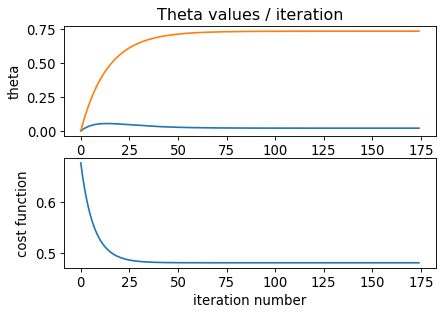

In [11]:
# set some plotting parameters (font size)
plt.rcParams.update({'font.size': 12})

# start a figure
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

# plot (with two sub-plots)
plt.subplot(2, 1, 1)
plt.plot(t_vals)
plt.title('Theta values / iteration')
plt.ylabel('theta')

plt.subplot(2, 1, 2)
plt.plot(c_vals)
plt.xlabel('iteration number')
plt.ylabel('cost function')
plt.show()

Here, a function is defined that performs the steps
above so that they can be called with a single line.

In [12]:
# define a function that does everything
def test_gradient_descent(numiter=1000):
    
    # loop
    for liter in range(numiter):
        
        # assign some values
        t = np.zeros(2,)
        X = np.empty([dataset_m, 2])
        X[:, 0] = 1
        X[:, 1] = np.random.randn(dataset_m)
        y = (np.random.randn(1,) +
             (0.5 + np.random.rand(1,)) * X[:, 1] +
             np.random.randn(dataset_m))
    
        # run function
        final_t, t_vals, c_vals = gradient_desc(
            linear_regression_cost, t, X, y, reg_lambda, learning_rate=learn_rate)

And we can measure the (average) time it takes for the function to complete

In [13]:
# time it
import timeit

%timeit test_gradient_descent()

1.53 s ± 5.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Or profile it, which prints much more information
as to which calls are the most "expensive" ones:

In [14]:
# profiling
import cProfile
cProfile.run('test_gradient_descent()')


         995808 function calls in 2.192 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.013    0.013    2.192    2.192 <ipython-input-12-9f7c066c81fd>:2(test_gradient_descent)
   281944    0.093    0.000    0.093    0.000 <ipython-input-3-8fdff92304bf>:3(jit_array_sum)
   140972    0.040    0.000    0.162    0.000 <ipython-input-4-7efeae57493a>:3(linear_regression_prediction)
   140972    1.287    0.000    1.674    0.000 <ipython-input-5-dad01d641bfe>:3(linear_regression_cost)
     1000    0.475    0.000    2.169    0.002 <ipython-input-7-e9d1d5a8db73>:2(gradient_desc)
        1    0.000    0.000    2.192    2.192 <string>:1(<module>)
        1    0.000    0.000    2.192    2.192 {built-in method builtins.exec}
   139972    0.018    0.000    0.018    0.000 {built-in method math.fabs}
     3000    0.002    0.000    0.002    0.000 {built-in method numpy.core.multiarray.empty}
   281944    0.254    0.000    0.25

The next set of functions is for logistic regression:

In [15]:
# define logistic regression prediction
def logistic_regression_prediction(theta, X):
    """
    logistic_regression_prediction returns the [m,] vector
    of predicted values given theta and X as the result of
    passing the matrix multiplication X * theta (or where
    for each value of the prediction theta.T * x, where x
    is the [n+1,] feature vector of a single sample) into
    the equation (1 / (1 + exp(X * theta)))
    
    input parameters:
        theta   - weights for the columns in X
        X       - design matrix (column of 1's and features)
    
    output:
        p_y     - predicted values for y, between [0 .. 1]
    
    note: ideally, features will already be normalized!
    """
    
    # return prediction
    return 1.0 / (1.0 + np.exp(-np.matmul(X, theta)))

In [16]:
# define logistic regression cost function
def logistic_regression_cost(theta, X, y, l = 0.0):
    """
    logistic_regression_cost computes the cost function for
    the logistic regression, such that the cost equals the
    mean over -log(pred(theta, X)) for y == 1 and
    -log(1 - pred(theta, X)) for y == 0.
    
    input parameters:
        theta   - weights for the columns in X
        X       - design matrix (column of 1's and features)
        y       - observed output (either 0 or 1 for each y[m])
        [l]     - optional regularization lambda (>= 0.0)
    
    output:
        J       - logistic regression cost J
        Jg      - partial derivaties (gradient) w.r.t. theta
    """
    
    # compute two terms
    p = logistic_regression_prediction(theta, X)
    p[p == 0] = 2.3e-16
    p[p == 1] = 1.0 - 2.3e-16
    e = p - y
    log1 = np.log(p)
    log0 = np.log(1.0 - p)
    
    # compute cost without lambda
    if l <= 0.0:
        J = (-1.0 / e.size) * (np.matmul(log1, y) + np.matmul(log0, 1.0 - y))
        Jg = (1.0 / e.size) * (np.matmul(X.T, e))
    else:
        J = ((-1.0 / e.size) * (np.matmul(log1, y) + np.matmul(log0, 1.0 - y)) +
             (l / (2.0 * e.size)) * jit_array_sum(np.multiply(theta[1:], theta[1:])))
        tc = l * theta
        tc[0] = 0.0
        Jg = (1.0 / e.size) * (np.matmul(X.T, e) + tc)
    return J, Jg

Create a derived (logistic suitable) example data set:

In [17]:
# assign some values
y_mean = np.mean(y)
y_binary = y
y_binary[y < y_mean] = 0.0
y_binary[y != 0.0] = 1.0

In [18]:
# find thetas
final_t, t_vals, c_vals = gradient_desc(
    logistic_regression_cost, t, X, y_binary, reg_lambda, learning_rate=learn_rate)

# print final_t
print(final_t)

[-0.17319389  1.23333884]


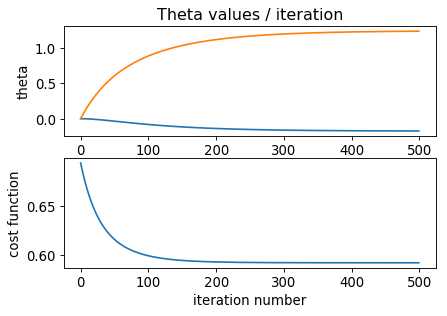

In [19]:
# start a figure
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

# plot (with two sub-plots)
plt.subplot(2, 1, 1)
plt.plot(t_vals)
plt.title('Theta values / iteration')
plt.ylabel('theta')

plt.subplot(2, 1, 2)
plt.plot(c_vals)
plt.xlabel('iteration number')
plt.ylabel('cost function')
plt.show()

Scatter values of X[:,1] (feature) /vs/ y_binary

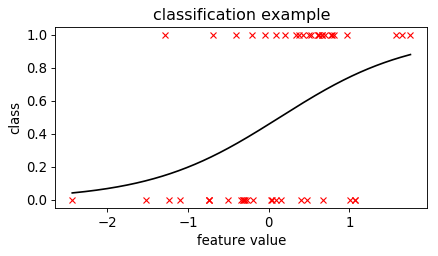

In [20]:
# start a figure
plt.figure(num=None, figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')

# plot
plt.plot(X[:, 1], y_binary, 'rx')
plt.title('classification example')
plt.xlabel('feature value')
plt.ylabel('class')

# add logistic (sigmoid) function
Xs = np.empty([1000, 2])
Xs[:, 0] = 1
Xs[:, 1] = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 1000)
plt.plot(Xs[:, 1], logistic_regression_prediction(final_t, Xs), '-k')
plt.show()